# High Value Customers Identification

## The All In One Place company

The All in One Place company is a Multibrand Outlet company. It sells second-line products of several brands at a lower price, through an e-commerce.

In just over 1 year of operation, the marketing team realized that some customers in its base buy more expensive products, with high frequency and end up contributing a significant portion of the company's revenue.

Based on this perception, the marketing team will launch a loyalty program for the best customers in the base, called Insiders. But the team does not have an advanced knowledge of data analysis to elect program participants.

For this reason, the marketing team asked the data team to select eligible customers for the program, using advanced data manipulation techniques.

---

## Project Objectives

You are part of All In One Place's team of data scientists who need to determine who are the eligible customers to be part of Insiders. In possession of this list, the Marketing team will carry out a sequence of personalized and exclusive actions to the group, in order to increase sales and purchase frequency.

As a result of this project, you are expected to submit a list of people eligible to participate in the Insiders program, along with a report answering the following questions:

1. Who are the people eligible to participate in the Insiders program?
2. How many customers will be part of the group?
3. What are the main characteristics of these customers?
4. What is the percentage of revenue contribution, coming from Insiders?
5. What is this group's revenue expectation for the coming months?
6. What are the conditions for a person to be eligible for Insiders?
7. What are the conditions for a person to be removed from Insiders?
8. What is the guarantee that the Insiders program is better than the rest of the base?
9. What actions can the marketing team take to increase revenue?

---

## Data 

The dataset is available on the [Kaggle platform](https://www.kaggle.com/vik2012kvs/high-value-customers-identification).

Each line represents a sale transaction, which took place between the period of November 2016 and December 2017.

The dataset includes the following information:
* InvoiceNo: Invoice number (A 6-digit integral number uniquely assigned to each transaction)
* StockCode: Product (item) code
* Description: Product (item) name
* Quantity: The quantities of each product (item) per transaction
* InvoiceDate: The day when each transaction was generated
* UnitPrice: Unit price (Product price per unit)
* CustomerID: Customer number (Unique ID assigned to each customer)
* Country: Country name (The name of the country where each customer resides)

# Summary
* [1. Invoices Dataframe](#1.)
    * [1.1 Missing Values](#1.1)
    * [1.2 New Features](#1.2)
    * [1.3 Negative Quantities](#1.3)
* [2. Customers Dataframe](#2.)
    * [2.1 Dataframe](#2.1)
    * [2.2 New Features](#2.2)
    * [2.3 Data Preprocessing](#2.3)
* [3. Model](#3.)
    * [3.1 K-Means](#3.1)
    * [3.2 Agglomerative Clustering](#3.2)
    * [3.3 DBSCAN](#3.3)
* [4. Conclusion](#4.)
    * [4.1 Who are the people eligible to participate in the Insiders program?](#4.1)
    * [4.2 How many customers will be part of the group?](#4.2)
    * [4.3 What are the main characteristics of these customers?](#4.3)
    * [4.4 What is the percentage of revenue contribution, coming from Insiders?](#4.4)
    * [4.5 What is this group's revenue expectation for the coming months?](#4.5)
    * [4.6 What are the conditions for a person to be eligible for Insiders?](#4.6)
    * [4.7 What are the conditions for a person to be removed from Insiders?](#4.7)
    * [4.8 What is the guarantee that the Insiders program is better than the rest of the base?](#4.8)
    * [4.9 What actions can the marketing team take to increase revenue?](#4.9)

# References
* [Targeting your most valuable customers in a post-Pareto world](https://www.dynamicyield.com/lesson/targeting-high-value-customers/)
* [What Is a High-Value Customer? [+5 Ways to Identify Them]](https://blog.hubspot.com/service/high-value-customer)

# Import the python libraries

In [1]:
# data analysis
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import sklearn.cluster as cluster
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.neighbors import NearestCentroid
from scipy.spatial import distance

# 1. Invoices Dataframe <a class='anchor' id='1.'></a>

In [2]:
df_inv = pd.read_csv('csv/Ecommerce.csv', encoding='ISO-8859-1')
df_inv.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,29-Nov-16,7.65,17850.0,United Kingdom,NaN
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,29-Nov-16,4.25,17850.0,United Kingdom,NaN
7,536366,22633,HAND WARMER UNION JACK,6,29-Nov-16,1.85,17850.0,United Kingdom,NaN
8,536366,22632,HAND WARMER RED POLKA DOT,6,29-Nov-16,1.85,17850.0,United Kingdom,NaN
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,29-Nov-16,1.69,13047.0,United Kingdom,NaN


In [3]:
df_inv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [4]:
df_inv.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909,0.0
unique,25900,4070,4223,NaN,305,NaN,NaN,38,NaN
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,3-Dec-17,NaN,NaN,United Kingdom,NaN
freq,1114,2313,2369,NaN,5331,NaN,NaN,495478,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN,NaN


## 1.1 Missing values <a class='anchor' id='1.1'></a>

In [5]:
print(f'Only features contained missing value in Training Dataset')
temp = df_inv.isnull().sum()
print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Dataset
Description      1454
CustomerID     135080
Unnamed: 8     541909
dtype: int64 



* Since we want to identify which customers are tthe most valued ones to the company, the rows with missing CustomerID are not relevant and can be dropped
* We can drop the Unnamed: 8 column, since it doesn't have any value
* We can ignore the missing values from the column Description, because the column StockCode is a reference to the same product and doesn't have any missing values

In [6]:
df_inv.drop('Unnamed: 8', axis=1, inplace=True)
df_inv.drop(df_inv[df_inv['CustomerID'].isnull()].index, inplace=True)
df_inv.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [7]:
df_inv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


As we can see, all the missing values from the column Description were removed when we deleted the rows that didn't have a CustomerID value

## 1.2 New Features <a class='anchor' id='1.2'></a>

* TotalValue: Total value of the transaction 
* InvoiceYear: Year when the transaction was generated
* InvoiceMonth: Month when the transaction was generated
* InvoiceSemester: Semester when the transaction was generated

In [8]:
df_inv['TotalValue'] = df_inv['Quantity']*df_inv['UnitPrice']
df_inv = pd.concat([df_inv, df_inv['InvoiceDate'].str.extract(r'(?P<InvoiceMonth>[A-Za-z]{3})-(?P<InvoiceYear>\d{2})')], axis=1)
df_inv['InvoiceMonth'] = pd.to_datetime(df_inv.InvoiceMonth, format='%b').dt.month
df_inv['InvoiceSemester'] = df_inv['InvoiceMonth'].apply(lambda x: 1 if x <= 6 else 2)
df_inv.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,InvoiceMonth,InvoiceYear,InvoiceSemester
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,15.30,11,16,2
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,20.34,11,16,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,22.00,11,16,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,20.34,11,16,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,20.34,11,16,2


## 1.3 Negative Quantities <a class='anchor' id='1.3'></a>

In [9]:
df_inv.describe()

,Quantity,UnitPrice,CustomerID,TotalValue,InvoiceMonth,InvoiceSemester
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854,7.541259,1.629046
std,248.693370,69.315162,1713.600303,427.591718,3.409613,0.483061
min,-80995.000000,0.000000,12346.000000,-168469.600000,1.000000,1.000000
25%,2.000000,1.250000,13953.000000,4.200000,5.000000,1.000000
50%,5.000000,1.950000,15152.000000,11.100000,8.000000,2.000000
75%,12.000000,3.750000,16791.000000,19.500000,11.000000,2.000000
max,80995.000000,38970.000000,18287.000000,168469.600000,12.000000,2.000000


In [10]:
df_inv[df_inv['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,InvoiceMonth,InvoiceYear,InvoiceSemester
141,C536379,D,Discount,-1,29-Nov-16,27.50,14527.0,United Kingdom,-27.50,11,16,2
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,29-Nov-16,4.65,15311.0,United Kingdom,-4.65,11,16,2
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,29-Nov-16,1.65,17548.0,United Kingdom,-19.80,11,16,2
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,29-Nov-16,0.29,17548.0,United Kingdom,-6.96,11,16,2
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,29-Nov-16,0.29,17548.0,United Kingdom,-6.96,11,16,2


In [11]:
sorted(df_inv[df_inv['Quantity'] < 0].where(df_inv['Description'].str.startswith('D'))['Description'].dropna().unique())

['DAIRY MAID LARGE MILK JUG',
 'DAIRY MAID STRIPE MUG',
 'DAIRY MAID TOASTRACK',
 'DAIRY MAID TRADITIONAL TEAPOT ',
 'DAISY HAIR BAND',
 'DAISY HAIR COMB',
 'DANISH ROSE BEDSIDE CABINET',
 'DANISH ROSE DECORATIVE PLATE',
 'DANISH ROSE DELUXE COASTER',
 'DANISH ROSE PHOTO FRAME',
 'DANISH ROSE ROUND SEWING BOX',
 'DANISH ROSE TRINKET TRAYS',
 'DARK BIRD HOUSE TREE DECORATION',
 'DECORATION  BUTTERFLY  MAGIC GARDEN',
 'DECORATION  PINK CHICK MAGIC GARDEN',
 'DECORATION SITTING BUNNY',
 'DECORATION WHITE CHICK MAGIC GARDEN',
 'DECORATION WOBBLY CHICKEN',
 'DECORATIVE CATS BATHROOM BOTTLE',
 'DECORATIVE FLORE BATHROOM BOTTLE',
 'DECORATIVE HANGING SHELVING UNIT',
 'DECORATIVE PLANT POT WITH FRIEZE',
 'DECORATIVE WICKER HEART LARGE',
 'DECORATIVE WICKER HEART MEDIUM',
 'DELUXE SEWING KIT ',
 'DENIM PATCH PURSE PINK BUTTERFLY',
 'DIAMANTE HAIR GRIP PACK/2 BLACK DIA',
 'DIAMANTE HAIR GRIP PACK/2 CRYSTAL',
 'DIAMANTE HAIR GRIP PACK/2 LT ROSE',
 'DIAMANTE HAIR GRIP PACK/2 MONTANA',
 'DIAMANTE H

In [12]:
df_inv[df_inv['Quantity'] < 0].where(df_inv['Description'] == 'Discount')['StockCode'].dropna().unique()

array(['D'], dtype=object)

As we can see there are no Description of 'Discount' misspelled and the only type of discount transactions are defined with the StockCode of 'D'

In [13]:
len(df_inv[df_inv['Quantity'] < 0])

8905

In [14]:
len(df_inv[df_inv['Quantity'] < 0].where(df_inv['InvoiceNo'].str.contains('C')))

8905

* All negative quantities transactions contains a C on it's InvoiceNo.
* We will consider these transactions as product returns and discounts (transactions described as discounts)

## 1.4 Data Analysis <a class='anchor' id='1.4'></a>

In [195]:
def add_value_vlabels(ax, xspace=0, yspace=0):
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if x_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(rect.get_height())

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(xspace, yspace),    # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [190]:
def add_value_hlabels(ax, xspace=0, yspace=0):
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 4
        x_value = rect.get_width()

        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if x_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(rect.get_width())

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(xspace, yspace),    # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

### 1.4.1 Country

* We could create an Insiders program for each country

In [75]:
df_country = df_inv.groupby('Country').agg({'TotalValue':np.sum, 'Quantity':np.sum, 'CustomerID':'nunique', 'InvoiceNo':'nunique', 'StockCode':len}).sort_values(by='TotalValue', ascending=False)
df_country = df_country.rename(columns={'StockCode':'ProductTransactions'})
df_country

,TotalValue,Quantity,CustomerID,InvoiceNo,ProductTransactions
Country,,,,,
United Kingdom,6.767873e+06,4008533,3950,19857,361878
Netherlands,2.846615e+05,200128,9,101,2371
EIRE,2.502852e+05,136329,3,319,7485
Germany,2.216982e+05,117448,95,603,9495
France,1.967128e+05,109848,87,458,8491
Australia,1.370773e+05,83653,9,69,1259
Switzerland,5.573940e+04,29778,21,71,1877
Spain,5.477458e+04,26824,31,105,2533
Belgium,4.091096e+04,23152,25,119,2069


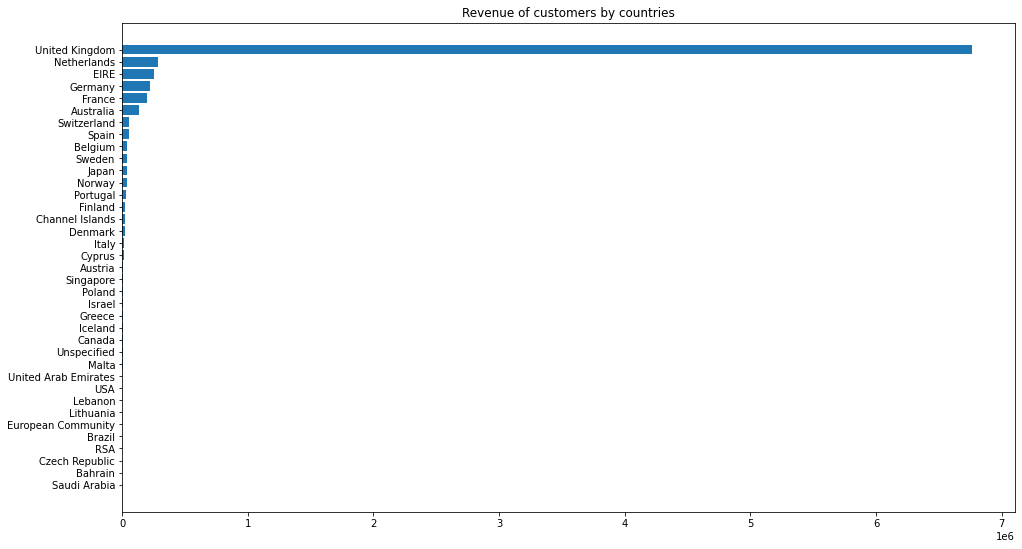

In [208]:
plt.figure(figsize=(16,9))
ax = plt.subplot(111)
plt.title('Revenue of customers by countries')
ax.barh(df_country.index[::-1], df_country['TotalValue'][::-1])
plt.show()

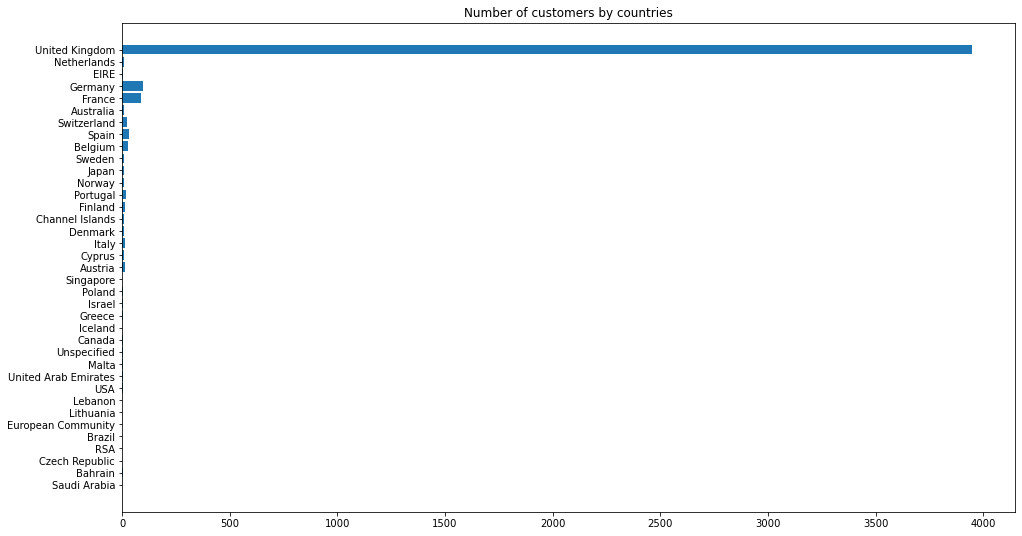

In [207]:
plt.figure(figsize=(16,9))
ax = plt.subplot(111)
plt.title('Number of customers by countries')
ax.barh(df_country.index[::-1], df_country['CustomerID'][::-1])
plt.show()

* As we can see, the revenue and the number of customers come majorly from the United Kingdom
* There are a lot of countries with less than 10 customers and some of them contribute a lot to the total revenue
* Defining a limit percentage of eligible people in a country could leave a high value customer out of the Insiders program
* We will not consider the country of the customer in the definition of eligible people of the Insiders program

### 1.4.2 Date

In [74]:
df_month = df_inv.groupby('InvoiceMonth').agg({'TotalValue':np.sum, 'Quantity':np.sum, 'CustomerID':'nunique', 'InvoiceNo':'nunique', 'StockCode':len})
df_month = df_month.rename(columns={'StockCode':'ProductTransactions'})
df_month

,TotalValue,Quantity,CustomerID,InvoiceNo,ProductTransactions
InvoiceMonth,,,,,
1,517832.540,293136,851,1370,24180
2,434829.260,259169,788,1192,20130
3,562237.380,341535,1002,1574,26928
4,409698.471,264783,872,1326,22509
5,684053.250,387077,1109,1954,30266
6,576932.380,340898,1015,1634,26902
7,602282.901,381813,1022,1638,28577
8,643654.230,404330,986,1604,28256
9,875995.672,502738,1259,1955,39700


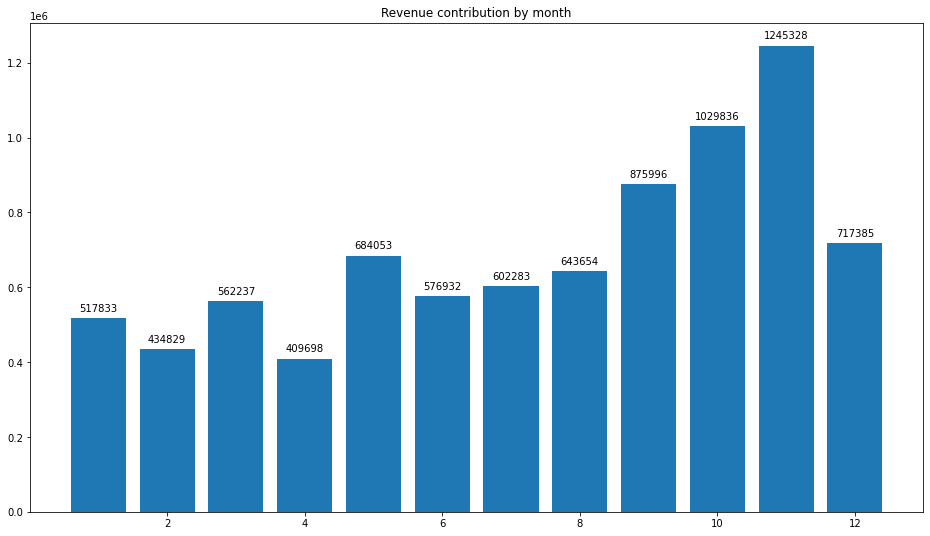

In [203]:
plt.figure(figsize=(16,9))
ax = plt.subplot(111)
plt.title('Revenue contribution by month')
ax.bar(df_month.index, df_month['TotalValue'])
add_value_vlabels(ax, yspace=5)
plt.show()

In [76]:
df_semester = df_inv.groupby('InvoiceSemester').agg({'TotalValue':np.sum, 'Quantity':np.sum, 'CustomerID':'nunique', 'InvoiceNo':'nunique', 'StockCode':len})
df_semester = df_semester.rename(columns={'StockCode':'ProductTransactions'})
df_semester

,TotalValue,Quantity,CustomerID,InvoiceNo,ProductTransactions
InvoiceSemester,,,,,
1,3.185583e+06,1886598,2757,9050,150915
2,5.114483e+06,3020290,3626,13140,255914


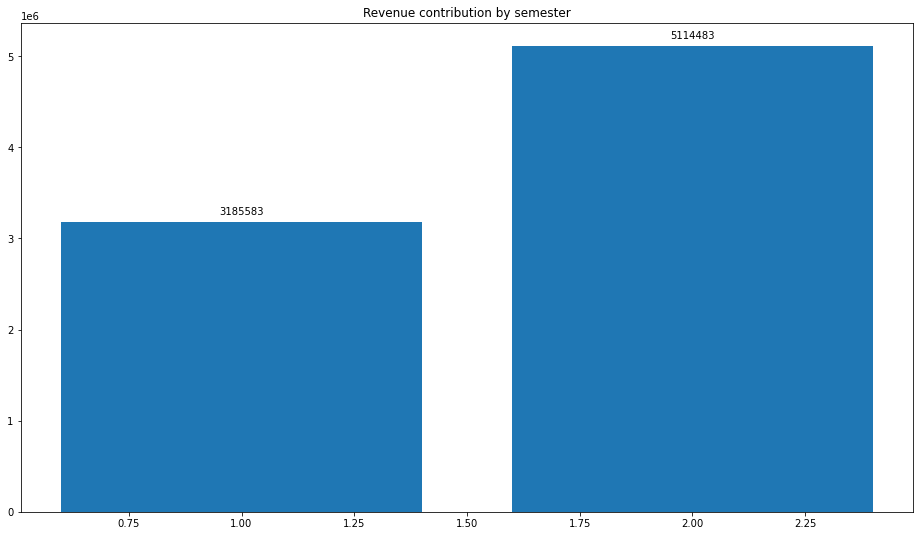

In [204]:
plt.figure(figsize=(16,9))
ax = plt.subplot(111)
plt.title('Revenue contribution by semester')
ax.bar(df_semester.index, df_semester['TotalValue'])
add_value_vlabels(ax, yspace=5)
plt.show()

In [77]:
df_semester.loc[1]/df_semester.loc[2]

TotalValue             0.622855
Quantity               0.624641
CustomerID             0.760342
InvoiceNo              0.688737
ProductTransactions    0.589710
dtype: float64

* The first semester of the year contributes almost 40% less than the second semester of the year in revenue
* February and April are the worst months of the year in terms of revenue contribution
* October and November are the best months of the year in terms of revenue contribution

### 1.4.3 Products

In [126]:
df_products = df_inv.groupby('Description').agg({'TotalValue':np.sum, 'Quantity':np.sum, 'CustomerID':'nunique', 'InvoiceNo':'nunique', 'Country':'nunique', 'UnitPrice':np.mean}).sort_values(by='TotalValue', ascending=False)
df_products.head(10)

,TotalValue,Quantity,CustomerID,InvoiceNo,Country,UnitPrice
Description,,,,,,
REGENCY CAKESTAND 3 TIER,132870.40,11555,887,1884,29,12.429423
WHITE HANGING HEART T-LIGHT HOLDER,93823.85,34147,858,2013,16,2.891362
JUMBO BAG RED RETROSPOT,83236.76,45066,636,1643,20,2.013057
PARTY BUNTING,67687.53,15027,708,1399,20,4.870805
POSTAGE,66710.24,3002,379,1194,23,37.888528
ASSORTED COLOUR BIRD ORNAMENT,56499.22,35314,679,1385,16,1.680860
RABBIT NIGHT LIGHT,51137.80,27094,450,816,19,2.014084
CHILLI LIGHTS,45936.81,9570,205,525,5,5.425226
PAPER CHAIN KIT 50'S CHRISTMAS,41500.48,15164,615,990,10,2.934606


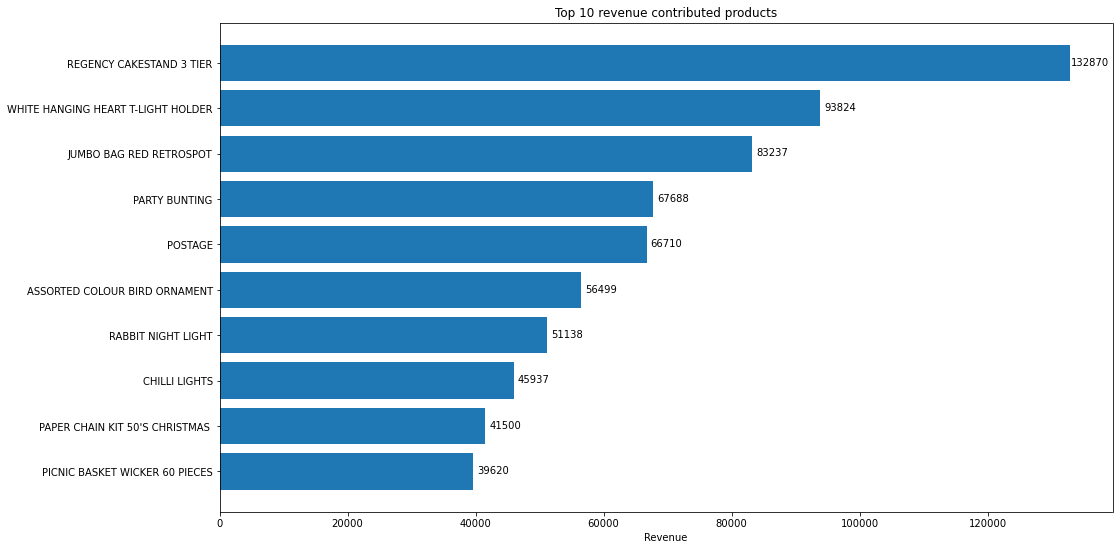

In [197]:
plt.figure(figsize=(16,9))
ax = plt.subplot(111)
plt.title('Top 10 revenue contributed products')
ax.barh(df_products.index[:10][::-1], df_products['TotalValue'][:10][::-1])
plt.xlabel('Revenue')
add_value_hlabels(ax, xspace=20, yspace=5)
plt.show()

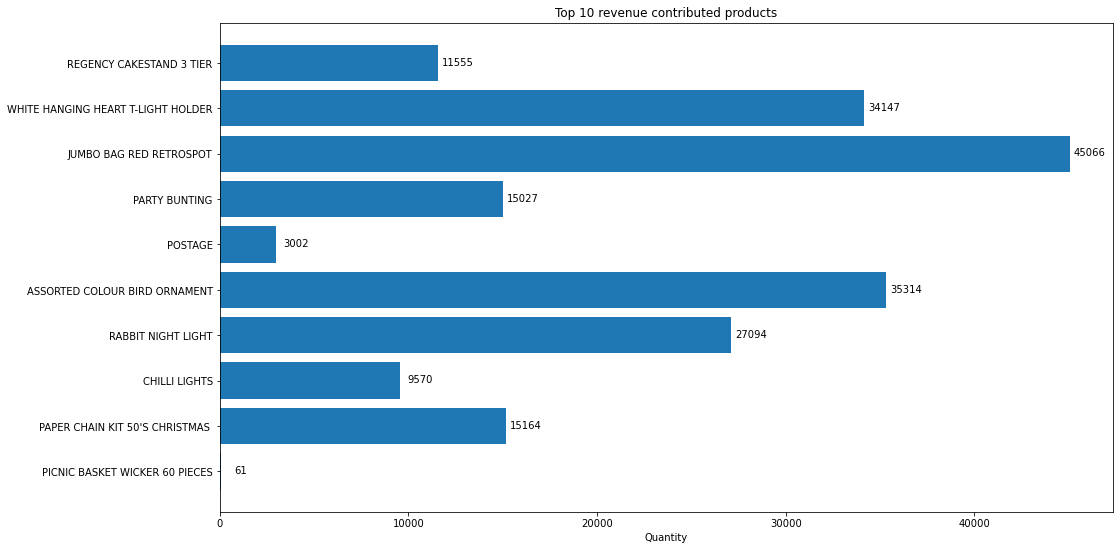

In [187]:
plt.figure(figsize=(16,9))
ax = plt.subplot(111)
plt.title('Top 10 revenue contributed products')
ax.barh(df_products.index[:10][::-1], df_products['Quantity'][:10][::-1])
plt.xlabel('Quantity')
add_value_hlabels(ax, xspace=20, yspace=5)
plt.show()

# 2. Customers Dataframe <a class='anchor' id='2.'></a>

## 2.1 Dataframe <a class='anchor' id='2.1'></a>

* create a new dataframe grouped by CustomerID
* The columns of the new dataframe must be:
    * Revenue: Sum of all transactions total value (including negative values (returns and discounts))
    * Quantity: Sum of all transactions quantities (including negative values (returns only))
    * First Transaction: Date of the first transaction of the customer
    * Last Transaction: Date of the last transaction of the customer
    * Transactions: Total number of transactions made by each customer (include all returns and discounts)

In [15]:
df_inv['InvoiceDate'] = pd.to_datetime(df_inv['InvoiceDate'])
df_inv['InvoiceDate2'] = pd.to_datetime(df_inv['InvoiceDate'])

df_cust = df_inv.groupby('CustomerID').agg({'TotalValue':np.sum, 'Quantity':np.sum, 'InvoiceDate':min, 'InvoiceDate2':max, 'InvoiceNo':'nunique'}).sort_values(by='TotalValue', ascending=False)
df_cust = df_cust.rename(columns={'TotalValue':'Revenue', 'InvoiceDate':'First Transaction', 'InvoiceDate2':'Last Transaction', 'InvoiceNo':'Transactions'})
df_cust.head()

,Revenue,Quantity,First Transaction,Last Transaction,Transactions
CustomerID,,,,,
14646.0,279489.02,196719,2016-12-18,2017-12-06,77
18102.0,256438.49,64122,2016-12-05,2017-12-07,62
17450.0,187482.17,69029,2016-12-05,2017-11-29,55
14911.0,132572.62,77180,2016-11-29,2017-12-06,248
12415.0,123725.45,77242,2017-01-04,2017-11-13,26


## 2.2 New Features <a class='anchor' id='2.2'></a>

### 2.2.1 Base Features 

* Returns: Number of return transactions
* Discounts: Number of discount transactions
* Purchases: Number of purchased product transactions

In [16]:
df_returns = df_inv[(df_inv['StockCode'] != 'D') & (df_inv['Quantity'] < 0)].groupby('CustomerID').agg({'TotalValue':len, 'InvoiceNo':'nunique'})
df_cust['Returns'] = df_cust.index.map(df_returns['InvoiceNo'])
df_cust.head()

,Revenue,Quantity,First Transaction,Last Transaction,Transactions,Returns
CustomerID,,,,,,
14646.0,279489.02,196719,2016-12-18,2017-12-06,77,2.0
18102.0,256438.49,64122,2016-12-05,2017-12-07,62,2.0
17450.0,187482.17,69029,2016-12-05,2017-11-29,55,9.0
14911.0,132572.62,77180,2016-11-29,2017-12-06,248,46.0
12415.0,123725.45,77242,2017-01-04,2017-11-13,26,5.0


In [17]:
df_discounts = df_inv[df_inv['StockCode'] == 'D'].groupby('CustomerID').agg({'TotalValue':len})
df_cust['Discounts'] = df_cust.index.map(df_discounts['TotalValue'])
df_cust.head()

,Revenue,Quantity,First Transaction,Last Transaction,Transactions,Returns,Discounts
CustomerID,,,,,,,
14646.0,279489.02,196719,2016-12-18,2017-12-06,77,2.0,1.0
18102.0,256438.49,64122,2016-12-05,2017-12-07,62,2.0,NaN
17450.0,187482.17,69029,2016-12-05,2017-11-29,55,9.0,1.0
14911.0,132572.62,77180,2016-11-29,2017-12-06,248,46.0,1.0
12415.0,123725.45,77242,2017-01-04,2017-11-13,26,5.0,NaN


Before creating the Purchases column, I will fill all the nan values with 0, to enable the substraction to occur

In [18]:
df_cust.fillna(0, inplace=True)
df_cust['Purchases'] = df_cust['Transactions'] - df_cust['Returns'] - df_cust['Discounts']
df_cust.head()

,Revenue,Quantity,First Transaction,Last Transaction,Transactions,Returns,Discounts,Purchases
CustomerID,,,,,,,,
14646.0,279489.02,196719,2016-12-18,2017-12-06,77,2.0,1.0,74.0
18102.0,256438.49,64122,2016-12-05,2017-12-07,62,2.0,0.0,60.0
17450.0,187482.17,69029,2016-12-05,2017-11-29,55,9.0,1.0,45.0
14911.0,132572.62,77180,2016-11-29,2017-12-06,248,46.0,1.0,201.0
12415.0,123725.45,77242,2017-01-04,2017-11-13,26,5.0,0.0,21.0


In [19]:
df_cust.describe()

,Revenue,Quantity,Transactions,Returns,Discounts,Purchases
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,1898.459701,1122.344007,5.075480,0.821134,0.017612,4.236734
std,8219.345141,4672.790720,9.338754,2.055851,0.558957,7.667089
min,-4287.630000,-303.000000,1.000000,0.000000,0.000000,0.000000
25%,293.362500,153.000000,1.000000,0.000000,0.000000,1.000000
50%,648.075000,365.000000,3.000000,0.000000,0.000000,2.000000
75%,1611.725000,962.250000,5.000000,1.000000,0.000000,5.000000
max,279489.020000,196719.000000,248.000000,46.000000,35.000000,210.000000


In [20]:
print('Number of CustomerIDs with negative TotalValue: ', len(df_cust[df_cust['Revenue'] < 0]))
print('Total number of transactions of these CustomerIDs: ', df_cust[df_cust['Revenue'] < 0]['Transactions'].sum())

Number of CustomerIDs with negative TotalValue:  43
Total number of transactions of these CustomerIDs:  67


* There are some CustomerIDs with negative TotalValue. These customers have some missing transactions. I will keep their transactions in the dataset, because they contribute to the total number of Customers.

### 2.2.2 Metric Features

* AOV: Average Order Value
* CLV: Customer Lifetime Value

#### 2.2.2.1 Average Order Value (AOV)

<p style='text-align:center'>$AOV = \frac{Revenue}{Number\,of\,Orders}$</p>

Where:
* Revenue: Revenue column
* Number of Orders: Transactions column

Reference: [Optimization glossary](https://www.optimizely.com/optimization-glossary/average-order-value/)

In [21]:
df_cust['AOV'] = df_cust['Revenue']/df_cust['Purchases']
df_cust.head()

,Revenue,Quantity,First Transaction,Last Transaction,Transactions,Returns,Discounts,Purchases,AOV
CustomerID,,,,,,,,,
14646.0,279489.02,196719,2016-12-18,2017-12-06,77,2.0,1.0,74.0,3776.878649
18102.0,256438.49,64122,2016-12-05,2017-12-07,62,2.0,0.0,60.0,4273.974833
17450.0,187482.17,69029,2016-12-05,2017-11-29,55,9.0,1.0,45.0,4166.270444
14911.0,132572.62,77180,2016-11-29,2017-12-06,248,46.0,1.0,201.0,659.565274
12415.0,123725.45,77242,2017-01-04,2017-11-13,26,5.0,0.0,21.0,5891.688095


#### 2.2.2.2 Customer Lifetime Value (CLV)

<p style='text-align:center'>$CLV = Average\,Transaction\,Size\,x\,Number\,of\,Transactions\,x\,Retention\,Period$</p>

Where:
* Average Transaction Size: AOV column
* Number of Transactions: Average number of transactions per month
    * create a new column: Transactions per Month
* Retention Period: How long the average customer stick with the brand
    * create a variable: retention_period

Reference: [Oracle netsuite](https://www.netsuite.com/portal/resource/articles/ecommerce/customer-lifetime-value-clv.shtml)

In [22]:
last_dataset_date = df_inv['InvoiceDate'].max()
last_dataset_date

Timestamp('2017-12-07 00:00:00')

In [23]:
df_cust['Transaction Period'] = ((last_dataset_date - df_cust['First Transaction'])/np.timedelta64(1, 'M'))
df_cust['Transaction Period'] = df_cust['Transaction Period'].apply(lambda x: x if x > 1 else 1)
df_cust['Transactions per Month'] = df_cust['Purchases']/df_cust['Transaction Period']
df_cust.head()

,Revenue,Quantity,First Transaction,Last Transaction,Transactions,Returns,Discounts,Purchases,AOV,Transaction Period,Transactions per Month
CustomerID,,,,,,,,,,,
14646.0,279489.02,196719,2016-12-18,2017-12-06,77,2.0,1.0,74.0,3776.878649,11.630629,6.362511
18102.0,256438.49,64122,2016-12-05,2017-12-07,62,2.0,0.0,60.0,4273.974833,12.057742,4.976056
17450.0,187482.17,69029,2016-12-05,2017-11-29,55,9.0,1.0,45.0,4166.270444,12.057742,3.732042
14911.0,132572.62,77180,2016-11-29,2017-12-06,248,46.0,1.0,201.0,659.565274,12.254872,16.401640
12415.0,123725.45,77242,2017-01-04,2017-11-13,26,5.0,0.0,21.0,5891.688095,11.072096,1.896660


* To create the 'Transactions per Month' column, I created the 'Transaction Period' column
* Transaction Period: result, in months, of the substraction of the final date of the dataset and each respective first transaction
* For rows with 'Transaction Period' < 0, I considered the value of 1 for this column
* Transaction per Month: divided the total number of purchases of each customer by the 'Transaction Period'. This way we can find out the average number of purchases transactions per month of each customer.

In [24]:
retention_period = np.mean(df_cust['Last Transaction'] - df_cust['First Transaction'])/np.timedelta64(1,'M')
retention_period

4.393453994999287

The retention period was calculated by the average value, in months, of the difference between the last transaction and the first transaction of each customer.

In [25]:
df_cust = df_cust.replace([np.inf, -np.inf], 0)
df_cust['CLV'] = df_cust['AOV']*df_cust['Transactions per Month']*retention_period
df_cust.head()

,Revenue,Quantity,First Transaction,Last Transaction,Transactions,Returns,Discounts,Purchases,AOV,Transaction Period,Transactions per Month,CLV
CustomerID,,,,,,,,,,,,
14646.0,279489.02,196719,2016-12-18,2017-12-06,77,2.0,1.0,74.0,3776.878649,11.630629,6.362511,105576.590492
18102.0,256438.49,64122,2016-12-05,2017-12-07,62,2.0,0.0,60.0,4273.974833,12.057742,4.976056,93437.947627
17450.0,187482.17,69029,2016-12-05,2017-11-29,55,9.0,1.0,45.0,4166.270444,12.057742,3.732042,68312.479852
14911.0,132572.62,77180,2016-11-29,2017-12-06,248,46.0,1.0,201.0,659.565274,12.254872,16.401640,47528.176403
12415.0,123725.45,77242,2017-01-04,2017-11-13,26,5.0,0.0,21.0,5891.688095,11.072096,1.896660,49094.776248


## 2.3 Data Preprocessing <a class='anchor' id='2.3'></a>

In [26]:
df_cust.describe()

,Revenue,Quantity,Transactions,Returns,Discounts,Purchases,AOV,Transaction Period,Transactions per Month,CLV
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,1898.459701,1122.344007,5.075480,0.821134,0.017612,4.236734,362.724976,7.427575,0.638173,1159.939097
std,8219.345141,4672.790720,9.338754,2.055851,0.558957,7.667089,400.776459,3.845707,0.748032,3486.710664
min,-4287.630000,-303.000000,1.000000,0.000000,0.000000,0.000000,-1165.300000,1.000000,0.000000,-583.623309
25%,293.362500,153.000000,1.000000,0.000000,0.000000,1.000000,171.969722,3.778312,0.228849,226.036106
50%,648.075000,365.000000,3.000000,0.000000,0.000000,2.000000,280.353333,8.312286,0.442987,550.878155
75%,1611.725000,962.250000,5.000000,1.000000,0.000000,5.000000,420.640000,10.874967,0.822618,1207.028236
max,279489.020000,196719.000000,248.000000,46.000000,35.000000,210.000000,7178.633333,12.254872,17.136042,105576.590492


<b>Checking the skewness of our dataset.</b>

* A normally distribuited data has a skewness close to zero.
* Skewness greather than zero means that there is more weight in the left side of the data.
* In another hand, skewness smaller than 0 means that there is more weight in the right side of the data

<p align='center'>
    <img src='images/skew.png'>
</p>

In [27]:
df_cust.skew()

Revenue                   21.705287
Quantity                  22.972932
Transactions              11.412274
Returns                    8.825832
Discounts                 57.042686
Purchases                 12.157586
AOV                        6.385498
Transaction Period        -0.361541
Transactions per Month     7.304233
CLV                       17.635722
dtype: float64

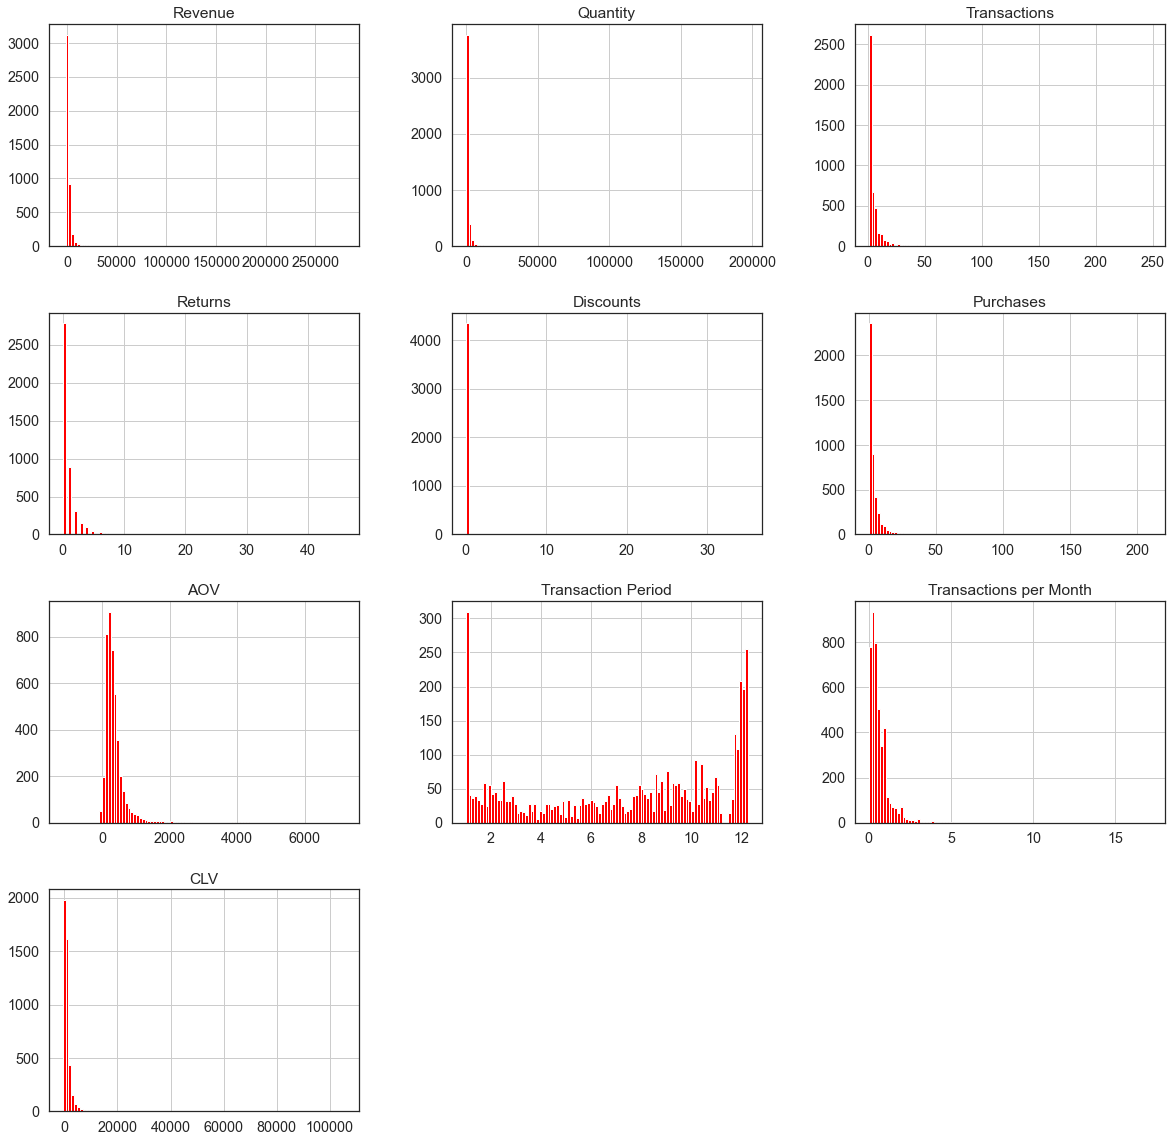

In [28]:
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(20,20)})
ax=df_cust.hist(bins=100,color='red' )

In [29]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
std_scaler = StandardScaler()
data_cluster = df_cust.select_dtypes(include=numerics).copy()
data_cluster[data_cluster.columns] = std_scaler.fit_transform(data_cluster)

In [30]:
data_cluster.describe()

,Revenue,Quantity,Transactions,Returns,Discounts,Purchases,AOV,Transaction Period,Transactions per Month,CLV
count,4.372000e+03,4.372000e+03,4.372000e+03,4.372000e+03,4.372000e+03,4.372000e+03,4.372000e+03,4.372000e+03,4.372000e+03,4.372000e+03
mean,7.846727e-17,-4.252215e-17,-5.535523e-15,-1.553145e-14,1.455060e-15,8.681223e-15,-4.040176e-16,5.793881e-16,7.413507e-16,1.020582e-16
std,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00
min,-7.527117e-01,-3.050655e-01,-4.364551e-01,-3.994592e-01,-3.151243e-02,-5.526502e-01,-3.813098e+00,-1.671555e+00,-8.532336e-01,-5.001166e-01
25%,-1.953052e-01,-2.074681e-01,-4.364551e-01,-3.994592e-01,-3.151243e-02,-4.222077e-01,-4.760187e-01,-9.490272e-01,-5.472644e-01,-2.678771e-01
50%,-1.521444e-01,-1.620938e-01,-2.222692e-01,-3.994592e-01,-3.151243e-02,-2.917652e-01,-2.055537e-01,2.300778e-01,-2.609631e-01,-1.747006e-01
75%,-3.488934e-02,-3.426482e-02,-8.083408e-03,8.701311e-02,-3.151243e-02,9.956237e-02,1.445236e-01,8.965285e-01,2.466016e-01,1.350686e-02
max,3.377669e+01,4.186343e+01,2.601549e+01,2.197827e+01,6.259228e+01,2.684028e+01,1.700870e+01,1.255387e+00,2.205754e+01,2.995046e+01


In [31]:
columns = ['Revenue', 'Purchases', 'AOV', 'CLV']
data_cluster = data_cluster[columns]

In [32]:
pca_2 = PCA(2)
pca_2_result = pca_2.fit_transform(data_cluster)

print ('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Cumulative variance explained by 2 principal components: 87.64%


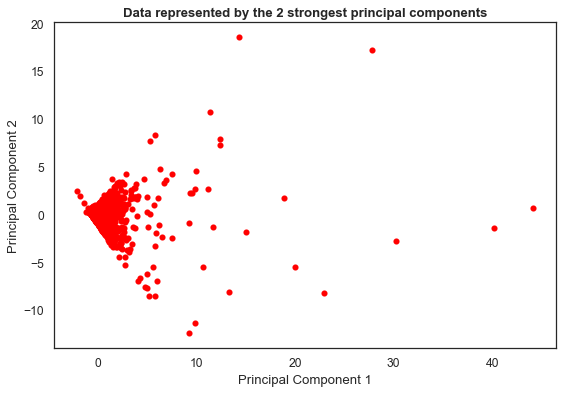

In [33]:
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='red',lw=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data represented by the 2 strongest principal components',fontweight='bold')
plt.show()

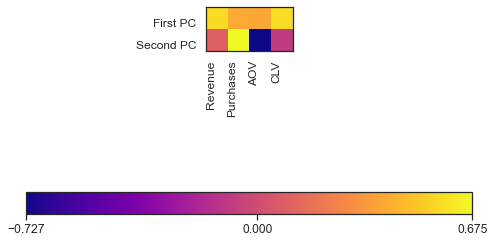

In [34]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca_2.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(data_cluster.columns)

plt.gca().set_xticks(np.arange(-.5, len(feature_names)-.5));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca_2.components_.min(), 0, 
                                              pca_2.components_.max()], pad=0.65);

# 3. Model <a class='anchor' id='3.'></a>

## 3.1 K-Means <a class='anchor' id='3.1'></a>
In order to define the number of clusters (K), we will combine the Silhouette Score and Inertia (Elbow plot analysis) techniques

In [35]:
inertia = []
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500)
    kmeans.fit(data_cluster)
    inertia.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.59it/s]


In [36]:
silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500)
    kmeans.fit(data_cluster)
    silhouette[i] = silhouette_score(data_cluster, kmeans.labels_, metric='euclidean')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.48it/s]


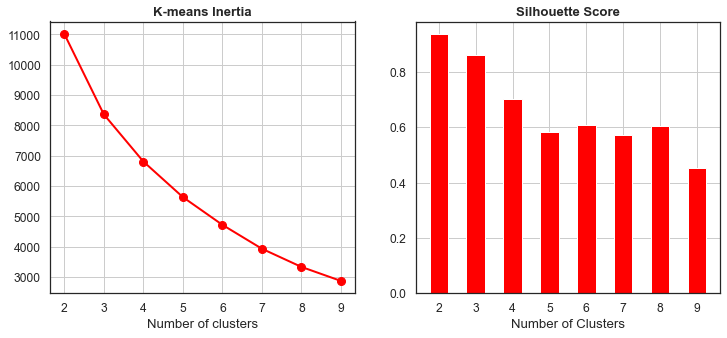

In [37]:
sns.set(style='white',font_scale=1.1, rc={'figure.figsize':(12,5)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8,color='red')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'red',width=0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid()
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Number of Clusters')


plt.show()

In [47]:
kmeans = cluster.KMeans(n_clusters=3,init='k-means++')
kmeans_labels = kmeans.fit_predict(data_cluster)

kmeans_centroids = kmeans.cluster_centers_
kmeans_centroids_pca = pca_2.transform(kmeans_centroids)

pd.Series(kmeans_labels).value_counts()

0    4228
2     137
1       7
dtype: int64

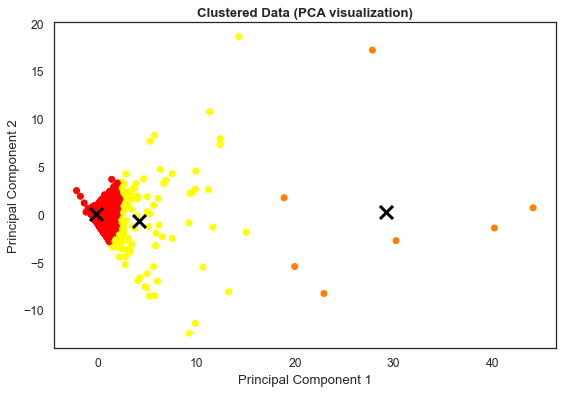

In [48]:
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='autumn')
plt.scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10,lw=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA visualization)',fontweight='bold')
plt.show()

## 3.2 Agglomerative Clustering <a class='anchor' id='3.2'></a>
In order to define the number of clusters (K), we will use a dendogram

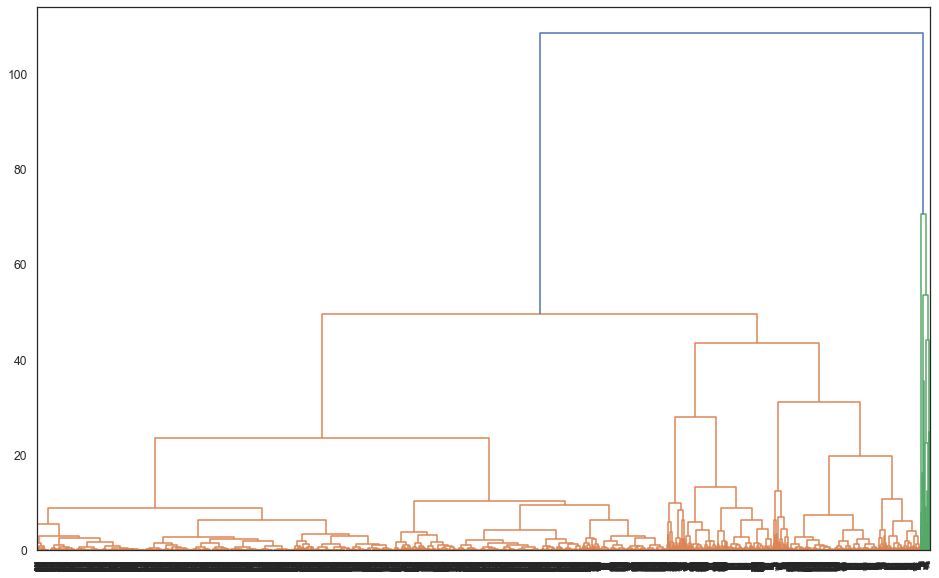

In [49]:
plt.figure(figsize=(16,10))
dendrogram(ward(data_cluster))
plt.show()

In [50]:
agg_clust = cluster.AgglomerativeClustering(n_clusters=2)
agg_clust_labels = agg_clust.fit_predict(data_cluster)

clf = NearestCentroid()
clf.fit(data_cluster, agg_clust_labels)

agg_clust_centroids = clf.centroids_
agg_clust_centroids_pca = pca_2.transform(agg_clust_centroids)

pd.Series(agg_clust_labels).value_counts()

1    4328
0      44
dtype: int64

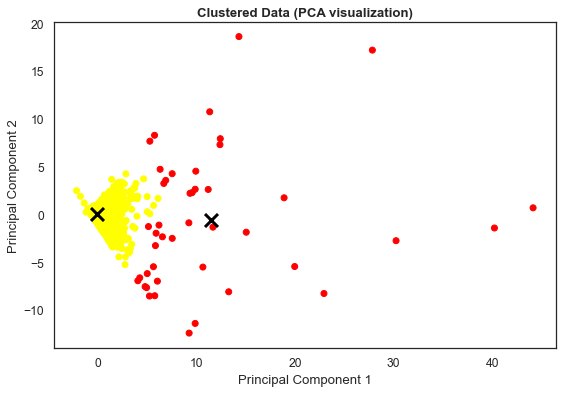

In [51]:
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=agg_clust_labels, cmap='autumn')
plt.scatter(agg_clust_centroids_pca[:, 0], agg_clust_centroids_pca[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10,lw=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA visualization)',fontweight='bold')
plt.show()

## 3.3 DBSCAN <a class='anchor' id='3.3'></a>

In [52]:
dbscan = cluster.DBSCAN(eps=2,min_samples=2)
dbscan_labels = dbscan.fit_predict(data_cluster)

clf = NearestCentroid()
clf.fit(data_cluster, dbscan_labels)

dbscan_centroids = clf.centroids_
dbscan_centroids_pca = pca_2.transform(dbscan_centroids)

pd.Series(dbscan_labels).value_counts()

 2    4337
-1      19
 3       8
 0       4
 1       2
 4       2
dtype: int64

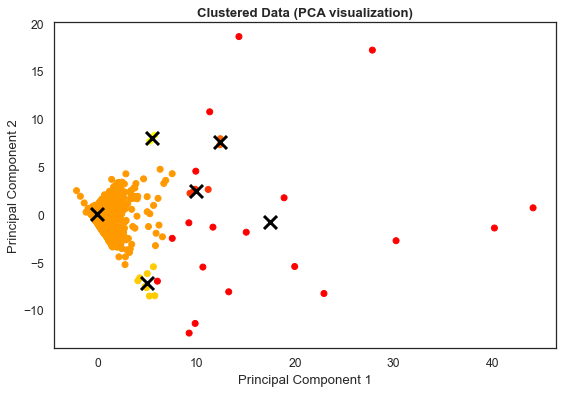

In [53]:
sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=dbscan_labels, cmap='autumn')
plt.scatter(dbscan_centroids_pca[:, 0], dbscan_centroids_pca[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10,lw=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA visualization)',fontweight='bold')
plt.show()

Analysing the 3 clustering algorithms results, I decided to use the <b>K-Means</b> algorithm. The 3 clusters provided the are:
* 0: Normal customers
* 1: Highest value customers
* 2: High value customers

We will include the clusters 1 and 2 into the Insiders group

In [54]:
df_clust = df_cust.copy()
df_clust['Cluster'] = kmeans_labels
df_clust.describe()

,Revenue,Quantity,Transactions,Returns,Discounts,Purchases,AOV,Transaction Period,Transactions per Month,CLV,Cluster
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,1898.459701,1122.344007,5.075480,0.821134,0.017612,4.236734,362.724976,7.427575,0.638173,1159.939097,0.064273
std,8219.345141,4672.790720,9.338754,2.055851,0.558957,7.667089,400.776459,3.845707,0.748032,3486.710664,0.350487
min,-4287.630000,-303.000000,1.000000,0.000000,0.000000,0.000000,-1165.300000,1.000000,0.000000,-583.623309,0.000000
25%,293.362500,153.000000,1.000000,0.000000,0.000000,1.000000,171.969722,3.778312,0.228849,226.036106,0.000000
50%,648.075000,365.000000,3.000000,0.000000,0.000000,2.000000,280.353333,8.312286,0.442987,550.878155,0.000000
75%,1611.725000,962.250000,5.000000,1.000000,0.000000,5.000000,420.640000,10.874967,0.822618,1207.028236,0.000000
max,279489.020000,196719.000000,248.000000,46.000000,35.000000,210.000000,7178.633333,12.254872,17.136042,105576.590492,2.000000


### Silhouette score
* It displays a measure of how close each point in a cluster is to points in the neighbouring clusters.<br>
* The higher the Silhouette Coefficients (the closer to +1), the further away the cluster’s samples are from the neighbouring clusters samples. 
* A value of 0 indicates that the sample is on or very close to the decision boundary between two neighbouring clusters. 
* Negative values, instead, indicate that those samples might have been assigned to the wrong cluster. 
* Averaging the Silhouette Coefficients, we can get to a global Silhouette Score which can be used to describe the entire population’s performance with a single value.

Reference: [Performance Metrics in Machine Learning — Part 3: Clustering](https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6)

In [55]:
print('The average silhouette score of the k-means algorithm with 3 clusters is {:.2%}'.format(silhouette[3]))

The average silhouette score of the k-means algorithm with 3 clusters is 85.96%


# 4. Conclusion <a class='anchor' id='4.'></a>

## 4.1 Who are the people eligible to participate in the Insiders program? <a class='anchor' id='4.1'></a>

In [56]:
df_clust[df_clust['Cluster'] != 0].index

Float64Index([14646.0, 18102.0, 17450.0, 14911.0, 12415.0, 14156.0, 17511.0,
              16684.0, 13694.0, 15311.0,
              ...
              15372.0, 16754.0, 14887.0, 14459.0, 16152.0, 16380.0, 16751.0,
              12349.0, 15947.0, 12398.0],
             dtype='float64', name='CustomerID', length=144)

* The customers eligible to participate in the Insiders program are all people from the clusters 1 and 2 (high value customers and highest value customers).
* The list of all eligible customers can be consulted above

## 4.2 How many customers will be part of the group? <a class='anchor' id='4.2|'></a>

In [57]:
len_insiders = len(df_clust[df_clust['Cluster'] != 0].index)
print('The Insiders group will be formed by {} customers'.format(len_insiders))

The Insiders group will be formed by 144 customers


## 4.3 What are the main characteristics of these customers? <a class='anchor' id='4.3'></a>

In [58]:
df_clust[df_clust['Cluster'] != 0].describe()

,Revenue,Quantity,Transactions,Returns,Discounts,Purchases,AOV,Transaction Period,Transactions per Month,CLV,Cluster
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,23123.039653,13078.333333,28.583333,4.937500,0.472222,23.173611,1625.094500,9.269454,2.187261,10866.815660,1.951389
std,39113.081236,22086.266796,37.592497,7.549574,3.042690,31.194479,1310.429054,3.869358,2.511380,15728.858089,0.215804
min,1635.660000,1.000000,1.000000,0.000000,0.000000,1.000000,125.955376,1.000000,0.081820,719.803643,1.000000
25%,6029.427500,3282.500000,4.000000,0.000000,0.000000,3.000000,657.913900,7.688043,0.528961,4113.056499,2.000000
50%,11943.265000,6013.000000,18.500000,2.000000,0.000000,15.000000,1383.905000,11.088523,1.565161,5748.895339,2.000000
75%,21039.582500,11115.750000,39.500000,6.000000,0.000000,31.000000,2023.665000,12.123452,2.853361,10165.260752,2.000000
max,279489.020000,196719.000000,248.000000,46.000000,35.000000,210.000000,7178.633333,12.254872,17.136042,105576.590492,2.000000


## 4.4 What is the percentage of revenue contribution, coming from Insiders? <a class='anchor' id='4.4'></a>

In [59]:
revenue_percentage = df_clust[df_clust['Cluster'] != 0]['Revenue'].sum()/df_clust['Revenue'].sum()
print('The percentage of revenue contribution of the Insiders is {:.2%}.'.format(revenue_percentage))

The percentage of revenue contribution of the Insiders is 40.12%.


## 4.5 What is this group's revenue expectation for the coming months? <a class='anchor' id='4.5'></a>

In [60]:
aov = df_clust[df_clust['Cluster'] != 0].describe()['AOV'].loc['mean']
transactions_per_month = df_clust[df_clust['Cluster'] != 0].describe()['Transactions per Month'].loc['mean']
individual_revenue_expectation = aov*transactions_per_month
total_revenue_expectation = individual_revenue_expectation * len_insiders
print("The Insiders group revenue expectation for the next months is {:,.2f} per month".format(total_revenue_expectation))

The Insiders group revenue expectation for the next months is 511,848.95 per month


## 4.6 What are the conditions for a person to be eligible for Insiders? <a class='anchor' id='4.6'></a>

* After computing the person data (Revenue, Number of Purchase Orders, AOV and CLV), the system will evaluate to what cluster this customer belongs.
* In general, after the PCA transformation needs to have a smaller euclidean distance from any of the centroids from the clusters 1 and 2 in comparison to the euclidean distance to the centroid of cluster 0.

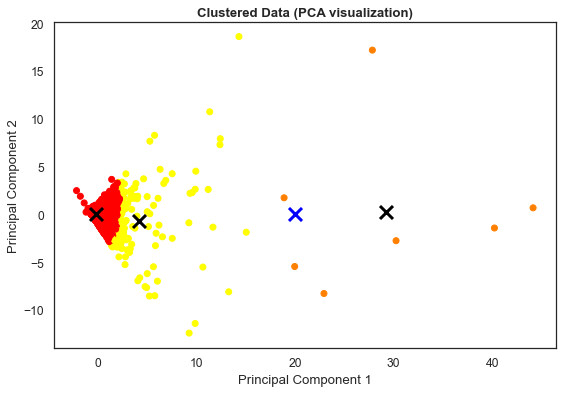

Euclidean distance o centroid 0: 20.18
Euclidean distance o centroid 1: 9.18
Euclidean distance o centroid 2: 15.86


In [61]:
new_customer = np.array([20,0])
new_customer

sns.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='autumn')
plt.scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10,lw=3)
plt.scatter(new_customer[0], new_customer[1], marker='x', s=169, linewidths=3,
            color='blue', zorder=10,lw=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA visualization)',fontweight='bold')
plt.show()

i=0
for center in kmeans_centroids_pca:
    print('Euclidean distance o centroid {}: {:.2f}'.format(i,distance.euclidean(center, new_customer)))
    i+=1

* In the example above, the customer (marked by the blue X) would be classified in the cluster 1 (Highest value customers), because the lowest euclidean distance found was from centroid 1.
* One condition to be eligible for the Insiders program is to maintain classified in cluster 1 or 2 for at least 6 months.

## 4.7 What are the conditions for a person to be removed from Insiders? <a class='anchor' id='4.7'></a>

* To be removed from the Insiders group, a customer needs to be classified in cluster 0 (Normal customers) for at least 3 months in a row.
* Another way is: every 365 days, the data of a customer in this period will be used to classify him/her into the 3 clusters. If the customer is classified as a normal customer in this one year interval, he/she will be removed from the Insiders program.

## 4.8 What is the guarantee that the Insiders program is better than the rest of the base? <a class='anchor' id='4.8'></a>

In [62]:
# Normal customers
df_clust[df_clust['Cluster'] == 0].describe().loc['mean']

Revenue                   1175.579022
Quantity                   715.139073
Transactions                 4.274834
Returns                      0.680937
Discounts                    0.002129
Purchases                    3.591769
AOV                        319.730366
Transaction Period           7.364843
Transactions per Month       0.585413
CLV                        829.335921
Cluster                      0.000000
Name: mean, dtype: float64

In [63]:
# Insiders
df_clust[df_clust['Cluster'] != 0].describe().loc['mean']

Revenue                   23123.039653
Quantity                  13078.333333
Transactions                 28.583333
Returns                       4.937500
Discounts                     0.472222
Purchases                    23.173611
AOV                        1625.094500
Transaction Period            9.269454
Transactions per Month        2.187261
CLV                       10866.815660
Cluster                       1.951389
Name: mean, dtype: float64

* As we can compare, all relevant mean values are way higher in the Insiders group.
* Since new customers that becomes eligible for the program will eventually be part of the program and customers that doesn't keep their averages enough will be removed, we guarantee that the Insiders will always be better than the rest.

## 4.9 What actions can the marketing team take to increase revenue? <a class='anchor' id='4.9'></a>

1. Reach out, survey, and learn from them (but actually) 

This idea was inspired by Peep Laja of CXL. Start by asking yourself: why are these people driving the most revenue? What causes them to buy more frequently and spend more on orders? What traffic sources or campaigns are they arriving from? What products are they searching for? What story does their clickstream data tell? What pain points were alleviated? Do they have additional needs that are not being met? 

Finding the answers to these questions will provide the foundation of a framework for creating audience segments and personalized experiences for your most valuable customers. Yet gut-reactions, guesses, and assumptions won’t get you very far. Have an executive or senior manager get in touch by phone or email and hear first-hand what these customers have to say. 

In addition, you can use a tool like Survey Monkey to create a short, free-form survey for valuable customers who purchased more recently (six months or less), asking them to explain their experience with your site and products and understand how you can improve their experience. 

Consider asking the following questions, adjusting as you see fit: 

How do you go about searching for and selecting products on our site? 
Is there any product you searched for but couldn’t find? 
Which aspects of our site/products do you like most? 
Which improvements in your life or business have you seen after using our product/site? 
If there was one thing we could do better what would it be? 
The better you know your most valuable customers, the better you can engage them and personalize their shopping experiences. 

2. Target different personas and audience groups with relevant experiences 

We know by now that personalization can deliver five to eight times the ROI on marketing spend, and can lift sales by 10% or more. With the help of omnichannel personalization engines, marketers can leverage prior behavioral data and apply micro-segmentation as well as machine learning algorithms to personalize the buying experiences of their most valuable customers.

For example, a large U.S. fashion retailer with six major sub-brands encouraged visitors to browse through more products by converting every homepage component into a dynamic element that targets different audience segments.

Reference: [Targeting your most valuable customers in a post-Pareto world](https://www.dynamicyield.com/lesson/targeting-high-value-customers/)